# Import Dependencies

In [278]:
!pip install rawpy

In [279]:
import os
import cv2
import rawpy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch as th

# Load Raw Images

In [280]:
def get_rgb_values(image_path, bayer_array=None, **kwargs):
    with rawpy.imread(image_path) as raw:
        if bayer_array is not None:
            raw.raw_image[:] = bayer_array
        rgb = raw.postprocess(**kwargs)
    return rgb

In [281]:
def load_raw_images(files_path):
    """Load raw images from the given path"""
    raw_images = []
    for path in files_path:
        with rawpy.imread(path) as raw:
            # print noise model of the raw image
            raw_images.append(raw.raw_image.copy())
    raw_images = np.stack(raw_images)
    raw_images = raw_images.astype(np.float32)
    return raw_images

In [282]:
# folder_path = "c1b1_20150226_144326_422"
folder_path = "0127_20161107_171749_524"
dng_files_path = ['../Dataset/20171106_subset/bursts/{}/{}'.format(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".dng")]

In [283]:
raw_images = load_raw_images(dng_files_path)
print("loaded raw images with shape: ", raw_images.shape)

loaded raw images with shape:  (9, 3044, 4048)


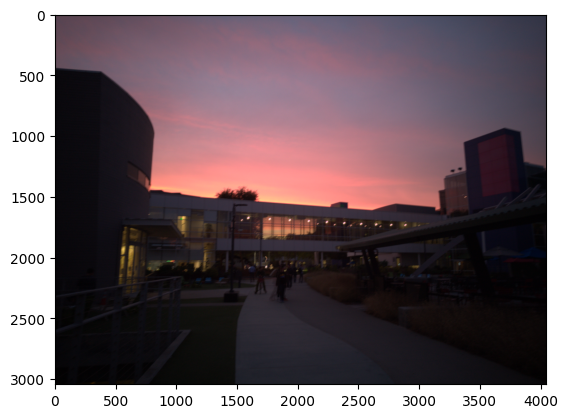

In [284]:
def naive_align(raw_images):
    """Find Average across all images"""
    return np.mean(raw_images, axis=0)

naive_aligned_image = naive_align(raw_images)
naive_rgb_image = get_rgb_values(dng_files_path[1], bayer_array=naive_aligned_image, no_auto_bright=False)

plt.imshow(naive_rgb_image)
plt.show()

# Aligning
- Use Handheld Multi-Frame Super-Resolution Paper (Google's approach to Super-Res Zoom and Night Sight Mode)
- Uses signals captured across multiple shifted frames to produce higher resolution images 

In [285]:
#  TODO: Verify correctness against dataset
def select_reference_image(raw_images):
    """Select the reference image from the given raw images"""
    gradient_magnitudes = []
    d_depth = cv2.CV_64F
    for i in range(raw_images.shape[0]):
        image = raw_images[i, :, :]
        sobel_x = cv2.Sobel(image, d_depth, 1, 0, ksize=3) 
        sobel_y = cv2.Sobel(image, d_depth, 0, 1, ksize=3) 

        # TODO: Optimize this by using the sum of the absolute values of the gradient
        gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2).sum()
        gradient_magnitudes.append(gradient_magnitude)

    return gradient_magnitudes.index(max(gradient_magnitudes))

max_gradient_magnitude_index = select_reference_image(raw_images[:3])

In [286]:
def gaussian_downsample(image, downsample_factor):
    """Downsample the given image using Gaussian pyramid"""
    downsampled_image = image
    two_d_kernel = cv2.getGaussianKernel(3, 0.1)

    for _ in range(downsample_factor//2):
        height, width = downsampled_image.shape[:2]
        downsampled_image = cv2.filter2D(downsampled_image, -1, two_d_kernel)
        downsampled_image = cv2.resize(downsampled_image, (width // 2, height // 2), interpolation=cv2.INTER_LINEAR)
    return downsampled_image

test_array = np.random.randint(0, 255, (512, 256)).astype(np.float32)
downsampled_image = gaussian_downsample(test_array, 4)
print("downsampled image shape: ", downsampled_image.shape)

downsampled image shape:  (128, 64)


In [287]:
def upsample_image(image, height, width):
    """Nearest-neighbor upsample the given image to the given shape"""
    if len(image.shape) > 3:
        return np.array([upsample_image(image[i], height, width) for i in range(image.shape[0])])
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_NEAREST)

test_array = np.random.randint(0, 255, (128, 64), dtype=np.int32)
downsampled_image = upsample_image(test_array, 512, 256)
print("upsampled image shape: ", downsampled_image.shape)

upsampled image shape:  (512, 256)


In [288]:
def generate_pyramid(images, pyramid_levels=4, downsample_factor=4):
    """Generate Gaussian pyramid for the given image"""
    pyramid_images = []
    for i in range(0, pyramid_levels):
        pyramid_level = []
        for j in range(images.shape[0]):
            if i == 0:
                pyramid_level.append(images[j])
            else:
                downsampled_image = gaussian_downsample(pyramid_images[-1][j], downsample_factor)
                pyramid_level.append(downsampled_image)
        pyramid_images.append(pyramid_level)
    return pyramid_images

pyramid_images = generate_pyramid(np.zeros_like(raw_images), pyramid_levels=4)
print(pyramid_images[0][0].shape, pyramid_images[1][0].shape, pyramid_images[2][0].shape, pyramid_images[3][0].shape)

(3044, 4048) (761, 1012) (190, 253) (47, 63)


In [289]:
# TODO: Consider out of the box alignment algorithms
# TODO: Consider using sparse motion vectors
def align_level_images(level, pyramid_level_images, motion_matrix, reference_image_index, block_size=16, search_window=4):
    level_reference_image = pyramid_level_images[reference_image_index]
    x_max, y_max = level_reference_image.shape

    for i in tqdm(range(raw_images.shape[0])):
        image_offset = motion_matrix[i]
        
        for x in range(0, x_max, block_size):
            for y in range(0, y_max, block_size):
                # Initialize the best match and the best match error
                best_match = np.zeros(3)
                best_match_error = np.inf

                end_x = min(x + block_size, x_max)
                end_y = min(y + block_size, y_max)

                reference_block = level_reference_image[x:end_x, y:end_y]
                offset = image_offset[x, y]

                for x_offset in range(-search_window + offset[0], search_window  + offset[0]):
                    for y_offset in range(-search_window + offset[1], search_window + offset[1]):

                        x_start = max(0, x + x_offset)
                        x_end = min(x + x_offset + block_size, x_max)

                        y_start = max(0, y + y_offset)
                        y_end = min(y + y_offset + block_size, y_max)

                        target_block = pyramid_level_images[i][x_start:x_end, y_start:y_end]

                        if reference_block.shape != target_block.shape:
                            continue

                        # L2 norm
                        if level < 2:
                            # [TODO]: Implement optimized L2 norm
                            block_error = np.sum((reference_block - target_block)**2)
                        else:
                            block_error = np.sum(np.abs(reference_block - target_block))

                        if block_error < best_match_error:
                            best_match_error = block_error
                            best_match = np.array([x_offset, y_offset, 0])

                motion_matrix[i][x:end_x, y:end_y, :] = best_match
    return motion_matrix

In [290]:
#[TODO]: Experiment with different search window sizes
#[TODO]: Optimize last level of pyramid
def burst_align(reference_image_index, raw_images):
    """Pyramid block matching algorithm"""
    pyramid_levels = 4
    downsample_factor = 4

    pyramid_images = generate_pyramid(raw_images, pyramid_levels, downsample_factor)
    # Arrange the pyramid images in descending order
    pyramid_images = pyramid_images[::-1]
    pyramid_shapes = [image[0].shape for image in pyramid_images]
    print("pyramid shapes: ", pyramid_shapes)

    # Initialize the motion vectors to zeros initially
    motion_matrix = np.zeros((raw_images.shape[0], pyramid_shapes[0][0], pyramid_shapes[0][1],  3), dtype=np.int32)

    for level in range(pyramid_levels):
        if level != 0:
            motion_matrix = upsample_image(motion_matrix, pyramid_shapes[level][0], pyramid_shapes[level][1]) * downsample_factor

        motion_matrix = align_level_images(level, pyramid_images[level], motion_matrix, reference_image_index, block_size=8 if level < 2 else 16, search_window=4)

        # Update the motion vectors
    return motion_matrix

In [291]:
def align(motion_matrix, raw_images, block_size=8):
    print(motion_matrix.shape, raw_images.shape)
    aligned_burst_patches = []
    for i in tqdm(range(raw_images.shape[0])):
        x_max, y_max = motion_matrix[i].shape[:2]
        aligned_image_patches = []

        for x in range(0, x_max, block_size):
            aligned_row_patches = []
            for y in range(0, y_max, block_size):
                best_match = motion_matrix[i][x, y]
                start_x = min(x + best_match[0], x_max)
                end_x = min(start_x + block_size, x_max)
                start_y = min(y + best_match[1], y_max)
                end_y = min(start_y + block_size, y_max)

                aligned_row_patches.append(raw_images[i][start_x:end_x, start_y:end_y])
            aligned_image_patches.append(aligned_row_patches)
        aligned_burst_patches.append(aligned_image_patches)

    return aligned_burst_patches

# Merge

In [292]:
# From IPOL article: https://www.ipol.im/pub/art/2021/336/article_lr.pdf
def patch_shift(patchSize, patchSize_y, noiseVariance, spatialFactor):
	'''Spatially denoise a set of 2D Frequency-domain patches
	Using a variant of the Wiener filter (Section 4.3 of the IPOL article).
	Args:
		patchesFFT: numpy array of 2D DFT (temporally denoised) patches of the reference image.
		noiseVariance: numpy array of the (updated) estimated noise variance for each patch
		spatialFactor: tuning factor that drives the compromise between less residual noise and loss of high frequency content.'''
	# create a patch of distance of spatial frequency module with respect to origin of spatial frequency axes
	# this patch will be used to filter higher frequency content more aggressively
	# WARNING: to avoid computing the FFT shift to the patches then FFT ishift,
	# This shift is applied directly to the distance
	rowDistances = (np.arange(patchSize) - patchSize / 2).reshape(-1, 1).repeat(patchSize_y, 1)
	columnDistances = rowDistances.T
	distancePatch = np.sqrt(rowDistances**2 + columnDistances**2)
	distPatchShift = np.fft.ifftshift(distancePatch, axes=(-2, -1))
	# Scale the noise variance to match the scale of np.abs(patchesFFT)**2
	noiseScaling = patchSize**2 * 1 / 4**2
	# Additional scaling according to spatial denoising strength tuning
	noiseScaling *= spatialFactor
	# Apply the Wiener filtering
	return distPatchShift * noiseScaling * noiseVariance

In [293]:

def cat2DPatches(patches):
	assert(len(patches.shape) == 4), "not a 2D array of 2D arrays"
	return np.concatenate(np.concatenate(patches, axis=1), axis=1)


def depatchifyOverlap(patches):
	'''recreates a single image out of a 2d arrangement
	of patches overlapped by half in each dimension
	'''
	assert(len(patches.shape) == 4), "not a 2D array of 2D patches"
	patchSize = patches.shape[-1]
	dp = patchSize // 2
	assert(patchSize == patches.shape[-2] and patchSize % 2 == 0), "function only supports square patches of even size"

	# separate the different groups of overlapped patches
	patchSet00 = patches[0::2, 0::2]  # original decomposition
	patchSet01 = patches[0::2, 1::2]  # straddled by patchSize/2 in horizontal axis
	patchSet10 = patches[1::2, 0::2]  # straddled by patchSize/2 in vertical axis
	patchSet11 = patches[1::2, 1::2]  # straddled by patchSize/2 half in both axes

	# recreate sub-images from the different patch groups
	imSet00 = cat2DPatches(patchSet00)
	imSet01 = cat2DPatches(patchSet01)
	imSet10 = cat2DPatches(patchSet10)
	imSet11 = cat2DPatches(patchSet11)

	# reconstruct final image by correctly adding sub-images
	reconstructedImage = np.zeros(((patches.shape[0] + 1) * dp, (patches.shape[1] + 1) * dp), dtype=imSet00.dtype)
	reconstructedImage[0 : imSet00.shape[0]     , 0 : imSet00.shape[1]     ]  = imSet00
	reconstructedImage[0 : imSet01.shape[0]     , dp: imSet01.shape[1] + dp] += imSet01
	reconstructedImage[dp: imSet10.shape[0] + dp, 0 : imSet10.shape[1]     ] += imSet10
	reconstructedImage[dp: imSet11.shape[0] + dp, dp: imSet11.shape[1] + dp] += imSet11
	return reconstructedImage

In [294]:
def merge_images(aligned_images, reference_image_index):
    """Merge the given raw images using the given motion matrix"""
    # [TODO]: What is the point of DFT here? Why can't we just use the motion matrix? 
    # [TODO]: Also this is prohibitively slow

    # TODO: Extract noise model from the dataset. A single value is enough because the assumption 
    # is that the noise is the roughly the same across all images shot from the same device
    
    # TODO: Consider per-patch noise model in place of global noise model
    shot_noise = 30.0
    read_noise = 5.0

    num_rows = len(aligned_images[0])
    num_cols = len(aligned_images[0][0])
    num_aligned_images = len(aligned_images)

    aligned_image = []
    for row in tqdm(range(num_rows)):
        aligned_row = []
        for col in range(num_cols):
            reference_image_patch = aligned_images[reference_image_index][row][col]
            path_rms = np.sqrt(np.mean(np.square(reference_image_patch)))
            dft_ref = th.fft.fftn(th.from_numpy(reference_image_patch), dim=(0, 1)).numpy()
            noise_variance = shot_noise * path_rms + read_noise
            temporal_factor = 8
            k = np.prod(reference_image_patch.shape) / 8
            noise = k * temporal_factor * noise_variance

            # Temporal Denoising
            final_patch = dft_ref.copy()
            for i in range(num_aligned_images):
                if i == reference_image_index:
                    continue
                alt_dft = np.array(aligned_images[i][row][col])
                # if dft_ref.shape != alt_dft.shape:
                #     continue
                alt_dft = th.fft.fftn(th.from_numpy(alt_dft), dim=(0, 1)).numpy()

                difference = dft_ref - alt_dft
                difference_squared = np.square(difference.real) + np.square(difference.imag)
                shrinkage_operator = difference_squared / (difference_squared + noise)
                final_patch += (1 - shrinkage_operator) * alt_dft + shrinkage_operator * dft_ref
            final_patch /= num_aligned_images

            # Spatial Denoising
            spatial_variance = patch_shift(reference_image_patch.shape[-1], reference_image_patch.shape[-1], noise_variance, 0.05)
            final_patch_squared = np.square(final_patch.real) + np.square(final_patch.imag)
            
            if final_patch_squared.shape != spatial_variance.shape:
                spatial_variance = spatial_variance[::2, ::]                
                shrinkage_operator = final_patch_squared / (final_patch_squared + spatial_variance)
                final_patch = shrinkage_operator * final_patch
                final_patch = th.fft.ifftn(th.from_numpy(final_patch), dim=(0, 1)).numpy().real
            else:
                shrinkage_operator = final_patch_squared / (final_patch_squared + spatial_variance)
                final_patch = shrinkage_operator * final_patch
                final_patch = th.fft.ifftn(th.from_numpy(final_patch), dim=(0, 1)).numpy().real
            # Upscale patch to simplify merging
            aligned_row.append(final_patch)
        aligned_image.append(aligned_row)
    return aligned_image

In [295]:
def merge_patches(final_patches):
    stacked_patches = []
    for row in final_patches:
        stacked_patches.append(np.hstack(row))
    return np.vstack(stacked_patches)


In [296]:
def align_and_merge_channel(raw_images):
    # A coarse-to-fine, pyramid-based block matching that creates a pyramid representation of every input frame and performs a limited window search to find the most similar tile

    # Downsample the raw images to speed up alignment
    downsampled_raw_images = np.array([gaussian_downsample(raw_image, 2) for raw_image in raw_images])
    print("downsampled raw images with shape: ", downsampled_raw_images[0].shape, "previous shape: ", raw_images[0].shape)

    # Generate alignment matrix using pyramid block matching
    motion_matrix = burst_align(max_gradient_magnitude_index, downsampled_raw_images)

    # Upsample the motion matrix to the original image size
    motion_matrix = upsample_image(motion_matrix, raw_images.shape[1], raw_images.shape[2]) * 2

    aligned_burst_patches = align(motion_matrix, raw_images)

    final_merged_frame = merge_images(aligned_burst_patches, max_gradient_magnitude_index)

    final_merged_bayer = merge_patches(final_merged_frame)

    return final_merged_bayer
merged_image = align_and_merge_channel(raw_images)

downsampled raw images with shape:  (1522, 2024) previous shape:  (3044, 4048)
pyramid shapes:  [(23, 31), (95, 126), (380, 506), (1522, 2024)]


100%|██████████| 9/9 [01:05<00:00,  7.26s/it]


(9, 3044, 4048, 3) (9, 3044, 4048)


100%|██████████| 381/381 [01:26<00:00,  4.42it/s]


In [297]:
def display_crop(reference_rgb, merged_rgb):
    # figure
    font_size = 14
    fig, axs = plt.subplots(1, 4, figsize=[20, 16])

    # crop
    crop_y = [200, 500]
    crop_x = [200, 500]

    # reference image
    axs[0].imshow(reference_rgb)
    axs[0].set_title('Reference image (full)', fontsize=font_size)
    axs[2].imshow(reference_rgb[crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1], :])
    axs[2].set_title('Reference image (crop)', fontsize=font_size)

    # merged burst
    axs[1].imshow(merged_rgb)
    axs[1].set_title('Merged image (full)', fontsize=font_size)
    axs[3].imshow(merged_rgb[crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1], :])
    axs[3].set_title('Merged image (crop)', fontsize=font_size)

    for ax in axs:
        ax.set_aspect(1)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f'before_and_after.jpg', bbox_inches='tight')
    plt.show()

final merged bayer shape:  (3044, 4048) previous shape:  (3044, 4048)
(3044, 4048, 3) 1075.2015593115543 28.131396436420516


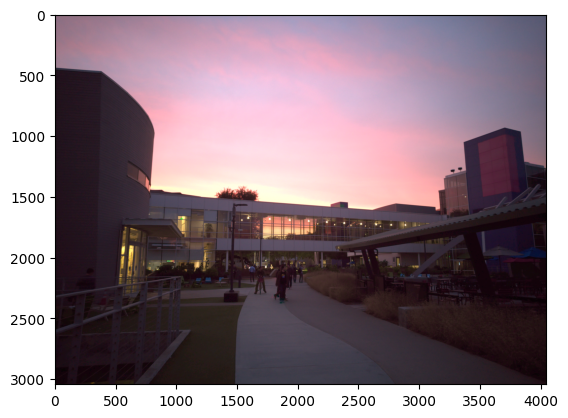

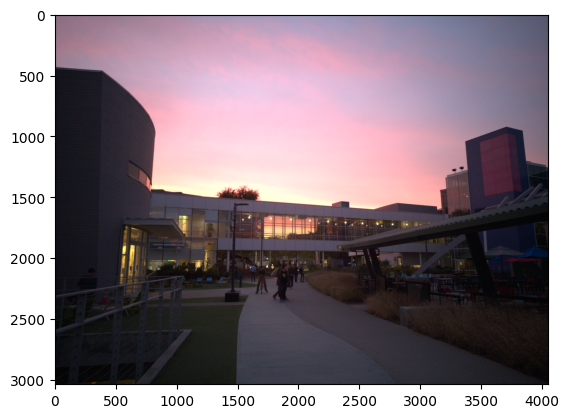

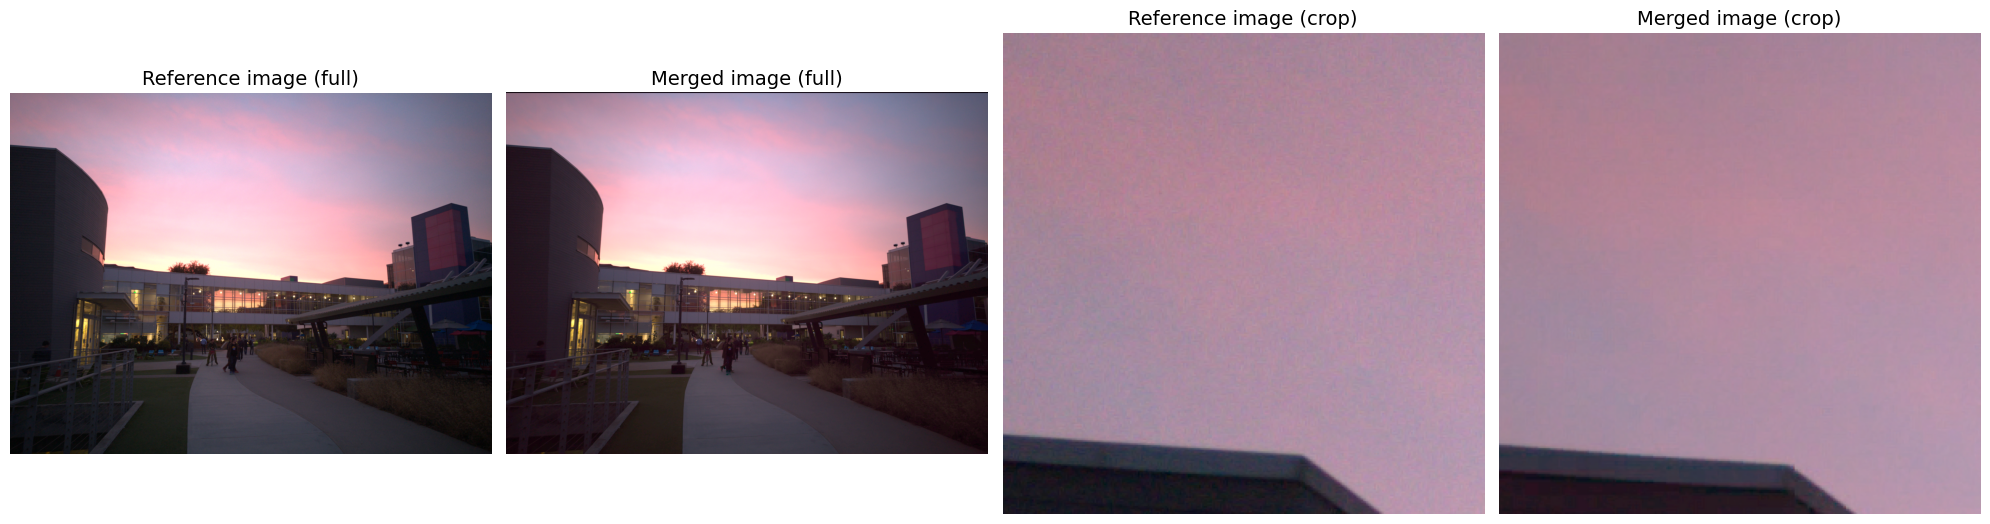

In [298]:
def demo_images():
    brigthness = 2.5

    print("final merged bayer shape: ", merged_image.shape, "previous shape: ", np.array(merged_image).shape)
    merged_rgb = get_rgb_values(dng_files_path[max_gradient_magnitude_index], merged_image, bright=brigthness, no_auto_bright=True)
    print(merged_rgb.shape, merged_image.max(), merged_image.min())
    merged_rgb = cv2.resize(merged_rgb, (raw_images.shape[2], raw_images.shape[1]), interpolation=cv2.INTER_LINEAR)
    plt.imsave('merged.jpg', merged_rgb)
    plt.imshow(merged_rgb)
    plt.show()

    ref_image_path = '../Dataset/20171106_subset/results_20161014/{}/merged.dng'.format(folder_path)
    reference_rgb = load_raw_images([ref_image_path])[0]
    reference_rgb = get_rgb_values(ref_image_path, bayer_array=reference_rgb, bright=brigthness, no_auto_bright=True)
    plt.imshow(reference_rgb)
    plt.show()

    display_crop(reference_rgb, merged_rgb)

# Finishing